# Long-sequence gate set tomography grid search

This notebook contains the results of the grid search done to determine the best set of parameters for the SPAM and gate Ginibre noise to perform LSGST using the Sandia ion trap data. It takes a significantly long time to run, so I have just left the original plots here.

The data is from:

Blume-Kohout, R. et al. Demonstration of qubit operations below a rigorous fault tolerance threshold with gate set tomography. Nat. Commun. 8, 14485 doi: 10.1038/ncomms14485 (2017).

The specific file, `2015_03_30-GST_BB1_XYXY_8192_condensed.txt`, from which experimental data is read, is from the supplementary information of the [original paper](https://www.nature.com/articles/ncomms14485), and can be downloaded [here](https://zenodo.org/record/231329). After downloading the file, it should be stored at the relative path `../data/lsgst/2015_03_30-GST_BB1_XYXY_8192_condensed.txt`


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.set_printoptions(suppress = True, precision = 6)

import qinfer as qi

import datetime

import csv
import os
import pandas as pd

from tqdm import tqdm

import oqt
from oqt.gates import GSeq
from oqt.distributions import ConstantStateDistribution, ConstantSuperoperatorDistribution, CombinedSPAMDistribution
from oqt.errors import GinibreNoise, DepolarizingChannel

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi': 150}
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Construct the gateset parameterization and the model. 

In [4]:
gateset_labels = ['Gi', 'Gx', 'Gy']
fiducial_labels=[[], ['Gx'], ['Gy'], ['Gx', "Gx"]]

param = oqt.linear_parameterization.GatesetParameterization(
    gateset_labels=gateset_labels, 
    fiducial_labels=fiducial_labels
)

model = qi.BinomialModel(oqt.linear_parameterization.GatesetModel(param))

Let's construct the set of true parameters, that we can use to compare with the experimental data as well as the model parameters we will reconstruct after OQT. 

In [5]:
# Perfect SPAM
vec_ρ = np.array([1, 0, 0, 1]) / np.sqrt(2) # preparing |0><0|
vec_E = np.array([1, 0, 0, 1]) / np.sqrt(2) # measuring |0><0|
ideal_spam = np.einsum("i,j->ij", vec_ρ, vec_E)

# Construct gate set tensor with perfect versions of all gates
gs_tensor_ideal = np.empty((), param.gs_tensor_dtype)
gs_tensor_ideal['Gx'] = oqt.gates.super_rot_x(np.pi/2)
gs_tensor_ideal['Gy'] = oqt.gates.super_rot_y(-np.pi/2)
gs_tensor_ideal['Gi'] = np.eye(4)
gs_tensor_ideal[str(oqt.gates.WellKnownGates.SPAM)] = ideal_spam

# Perfect model parameters
true_params = param.gs_tensor_to_modelparams(np.array([gs_tensor_ideal]))

## Gather experimental data

Rather than using a heuristic to generate the sequences, we're going to read in the sequences, as well as experimental data, directly from the Sandia group's supplementary material. This next code fragment does all this based on the structure of the file, and then parses it using regex (thanks Gary!) into sequences and count data.

In [6]:
import re
import subprocess

# Here we're going to gather all the experimental data from the file
filename = "../data/lsgst/2015_03_30-GST_BB1_XYXY_8192_condensed.txt"

# Get the total number of experiments; one per line, I've deleted the header from the original
num_experiments = int(subprocess.check_output(["wc", "-l", filename]).split()[0])
max_experiments = num_experiments

# Store experiments as experiment object and outcomes as outcomes
experiments = []
outcomes = []

# Now pull the data; we pull the first 3 columns, the sequence, and the counts/total counts
# The sequence is the trickiest as we will have to parse it and turn it into a GSeq object

# The regex groups into 3 sections - some sequence of GxGy..., then a (germ)^exp, then another GxGi...
# We'll parse them separately afterwards (assuming all gate identifiers are 2 chars long),
# to build up the actual sequence
pattern = r"(\w*)(\((.*)\)\^\d+)?(.*)?"

with open(filename) as infile:
    for exp_idx, line in enumerate(infile):
        if exp_idx > max_experiments: 
            break 
            
        read_exp_data = line.split()[0:3] # past tense of read!
        current_seq = read_exp_data[0]
        recorded_counts, total_shots = int(float(read_exp_data[1])), int(read_exp_data[2])
        
        # Parse the sequence... group by the patterns then tokenize
        # indices 1, 2, 4 are based on the structure of the regex
        grouped = re.match(pattern, current_seq)
        tokens = list(filter(None, [grouped.group(1), grouped.group(2), grouped.group(4)]))
        
        new_experiment = np.empty((1,), dtype=model.expparams_dtype)
        
        gate_sequence = GSeq()
                
        if exp_idx > 0:
            for token in tokens:
                # Get the alphabetical sequence of gates from this token
                alpha_gate_list = re.findall("[a-zA-Z]+", token)[0] 
                alpha_gate_seq = [alpha_gate_list[i:i+2] for i in range(0, len(alpha_gate_list), 2)]
    
                if "(" in token: # Case where there is a paren and then an exponent
                    exponent = int(re.findall("[0-9]+", token)[0])
                    if len(alpha_gate_seq) == 1:
                        gate_sequence += GSeq((alpha_gate_seq[0], exponent))
                    else: # Make a GSeq inside a GSeq so matrix multiplication works (FAST) from inside out
                        gate_sequence += GSeq((GSeq(*alpha_gate_seq), exponent))
                else:
                    gate_sequence += GSeq(alpha_gate_seq)
            
        new_experiment[0]['sequence'] = gate_sequence
        new_experiment[0]['n_meas'] = total_shots
        new_outcomes =  recorded_counts
        
        experiments.append(new_experiment)
        outcomes.append(new_outcomes)
        
full_experiments = experiments
full_outcomes = outcomes

num_experiments = len(full_experiments)

### Test experiments

We are going to set aside a number of experiments for the purpose of testing afterwards; these are experiments that specifically have the form ${G^{2^n}}$ for $n = 0,\ldots13$ and $G$ being all possible gates in the set, $G_i, G_x, $ and $G_y$. 

In [7]:
num_test_experiments = 14
gate_powers = [2 ** x for x in range(num_test_experiments)]

test_experiments = []

n_shots = full_experiments[0]['n_meas']

for gate in param.gateset_labels:
    for power in gate_powers:
        gate_sequence = GSeq()
        new_experiment = np.empty((1,), dtype=model.expparams_dtype)
        new_experiment[0]['sequence'] = gate_sequence + GSeq((gate, power))
        new_experiment[0]['n_meas'] = n_shots
        test_experiments.append(new_experiment)

## Grid search

Here we do a grid search over varying strength of Ginibre noise for both SPAM, and the individual gates. This takes a significant amount of time to run, I estimate close to 30h done in series. The full set of results is saved in a csv file, with information about the completion percentage. I have left those plots in the notebook so they are easy to see.

In [15]:
gate_ginib_eps  = [1e-5, 2e-5, 4e-5, 8e-5,
                   1e-4, 2e-4, 4e-4, 8e-4,
                   1e-3, 2e-3, 4e-3, 8e-3]

state_ginib_eps = [1e-5, 2e-5, 4e-5, 8e-5,
                   1e-4, 2e-4, 4e-4, 8e-4,
                   1e-3, 2e-3, 4e-3, 8e-3,
                   1e-2, 2e-2, 4e-2, 8e-2]

output_prefix = "../data/lsgst/grid-search/"
csv_filename = f"{output_prefix}gate-newspam-fullsweep.csv"
csv_header = ['GATE', 'STATE', 'COMPLETION', 'EXPERIMENT']

In [ ]:
with open(csv_filename, 'w') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(csv_header)
    
    for gate_eps in gate_ginib_eps:
        for state_eps in state_ginib_eps:
            print(f"Running gate ginib {gate_eps}, SPAM ginib {state_eps}")

            ρ_distribution = ConstantStateDistribution(vec_ρ, channel_error=GinibreNoise(eps=state_eps))
            E_distribution = ConstantStateDistribution(vec_E, channel_error=GinibreNoise(eps=state_eps))

            unknown_operators = {'Gi' : ConstantSuperoperatorDistribution(
                                                             np.eye(4), 
                                                             channel_error=[GinibreNoise(eps=gate_eps)]
                                        ),

                                 'Gx' : ConstantSuperoperatorDistribution(
                                                             oqt.gates.super_rot_x(np.pi/2),
                                                             channel_error=[GinibreNoise(eps=gate_eps)]
                                        ),

                                 'Gy' : ConstantSuperoperatorDistribution(
                                                             oqt.gates.super_rot_y(-np.pi/2),
                                                             channel_error=[GinibreNoise(eps=gate_eps)]
                                        ),

                                 'WellKnownGates.SPAM' : CombinedSPAMDistribution(
                                                             state=ρ_distribution, 
                                                             measurement=E_distribution
                                                         )
                                }

            prior = oqt.distributions.GSTProductDistribution(param, unknown_operators=unknown_operators)

            # Set up the particle and SMC updater
            n_particles = 10000
            updater = qi.SMCUpdater(model, n_particles, prior)

            # Now run the SMC updater

            try:
                for idx_experiment in range(num_experiments):
                    # Skip over any experiments that are also in the testing set
                    if full_experiments[idx_experiment] not in test_experiments:
                        experiment = full_experiments[idx_experiment]
                        datum = 50 - full_outcomes[idx_experiment]

                        with qi.perf_testing.numpy_err_policy(invalid='raise'):
                            updater.update(datum, experiment)

                print(f"Success for combination gate={gate_eps}, state={state_eps}")
                np.save(f"{output_prefix}-gate{gate_eps}-state{state_eps}-locs", updater.particle_locations)    
                np.save(f"{output_prefix}-gate{gate_eps}-state{state_eps}-wgts", updater.particle_weights)
            except:
                print(f"Failure for combination gate={gate_eps}, state_indiv={state_eps}")
                print(f"Failed at experiment {idx_experiment}, {100*idx_experiment/num_experiments:.1f}%")
                
            print()
            csv_writer.writerow([gate_eps, state_eps, 100*(idx_experiment+1)/num_experiments, idx_experiment])

## Analysis

This is the set of gauge-fixed superoperators that was reconstructed from the same data in the original LSGST paper. It can be found in the supplementary materials in the same location as the experimental outcome data. 

In [8]:
pygsti_best_fit = np.empty((), param.gs_tensor_dtype)

pygsti_best_fit['Gx'] = np.array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                                  [ 4.20528992e-07,  9.99946258e-01,  5.39449377e-05, -6.46354140e-06],
                                  [ 4.02238460e-06,  1.86119648e-05,  5.10510551e-05, -9.99904465e-01],
                                  [-3.71625636e-07,  4.42074230e-05,  9.99903844e-01,  5.66471749e-05]])

pygsti_best_fit['Gy'] = np.array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                                  [-2.84461040e-06,  1.72816657e-05,  2.03294042e-05,  9.99875670e-01],
                                  [-4.41163804e-06, -1.60461436e-05,  9.99962425e-01,  6.49955313e-06],
                                  [ 1.08371997e-06, -9.99875918e-01,  2.51775920e-05, -4.54572651e-05]])

pygsti_best_fit['Gi'] = np.array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                                  [ 2.10177470e-06,  9.99931872e-01, -6.44198677e-05,  1.01922740e-05],
                                  [ 6.43859878e-06,  2.76865350e-05,  9.99890681e-01,  2.23798528e-05],
                                  [-1.53446482e-06, -2.58386951e-05, -5.68170561e-05,  9.99899616e-01]])

pygsti_rho0 = np.array([[ 0.70710678],
                        [ 0.00242797],
                        [-0.00602108],
                        [ 0.70158617]])

pygsti_E = np.array([[0.7121799 ],
                     [0.00075139],
                     [0.00085205],
                     [0.70162408]]).T 

pygsti_best_fit[str(oqt.gates.WellKnownGates.SPAM)] = pygsti_rho0 * pygsti_E

pygsti_params = param.gs_tensor_to_modelparams(np.array([pygsti_best_fit]))

We need to simulate data for these new experiments and look at the counts we get. We'll use the mean over the posterior as our 'reconstructed gateset'.

Calculate and plot the likelihood instead of counts from a simulated experiment. For the experimental values, we will plot the observed frequencies using the data taken over 50 counts.

In [9]:
Gx_experimental_likelihood = np.array([25, 50, 0, 0, 1, 0, 0, 0, 1, 1, 0, 7, 12, 21]) / 50
Gy_experimental_likelihood = np.array([28, 50, 0, 1, 0, 0, 0, 0, 0, 3, 2, 5, 13, 22]) / 50
Gi_experimental_likelihood = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 4, 9, 19]) / 50

In [10]:
# Parameters for test experiments - (gate)^power where the powers are powers of 2
def compute_likelihood_comparison(gate, experimental_likelihood, particle_locations, particle_weights):
    single_gate_test_experiments = []

    n_shots = full_experiments[0]['n_meas']

    for power in gate_powers:
        new_experiment = np.empty((1,), dtype=model.expparams_dtype)
        new_experiment['sequence'] = GSeq((gate, power))
        new_experiment['n_meas'] = n_shots
        single_gate_test_experiments.append(new_experiment)

    oqt_likelihood = np.empty(len(gate_powers))
    true_likelihood = np.empty(len(gate_powers))
    pygsti_likelihood = np.empty(len(gate_powers))
    
    reconstructed_params = np.array([np.sum(particle_weights * particle_locations, axis = 0)])
    
    for idx_experiment, experiment in enumerate(single_gate_test_experiments):
        oqt_likelihood[idx_experiment] = model.underlying_model.likelihood(outcomes, reconstructed_params, experiment)[0, :, 0]
        true_likelihood[idx_experiment] = model.underlying_model.likelihood(outcomes, true_params, experiment)[0, :, 0]
        pygsti_likelihood[idx_experiment] = model.underlying_model.likelihood(outcomes, pygsti_params, experiment)[0, :, 0]

    return oqt_likelihood, true_likelihood, pygsti_likelihood

In [11]:
# For a given gate, make a plot of the likelihoods for the true case, the experiment, the OQT reconstruction, 
# and the pyGSTi reconstruction. This matches plot 1c in the Sandia paper. 
def plot_1c(gate, oqt_likelihood, true_likelihood, pygsti_likelihood, experimental_likelihood, ax=None):      
    if ax is None:
        ax = plt.gca()
    ax.semilogx(gate_powers, oqt_likelihood)
    ax.scatter(gate_powers, oqt_likelihood)
    ax.semilogx(gate_powers, true_likelihood)
    ax.scatter(gate_powers, true_likelihood)
    ax.semilogx(gate_powers, 1 - pygsti_likelihood)
    ax.scatter(gate_powers, 1 - pygsti_likelihood)
    ax.semilogx(gate_powers, experimental_likelihood)
    ax.scatter(gate_powers, experimental_likelihood)
    ax.set_xlabel(f'Power ({gate})^k')
    ax.set_ylabel('Sequence probability')
    ax.set_ylim([-0.05, 1.05])
    ax.set_title(f'Sequence probability vs. number of {gate} button presses')
    ax.legend(['OQT posterior mean', 'Ideal', 'pyGSTi', 'Experiment'])

In [28]:
# Compute and plot the total variation distance
def tvd(p, q):
    return np.abs(p - q)

def total_tvd(p, q):
    return 0.5 * np.sum(np.abs(p - q))

def plot_tvd(gate, oqt_tvd, pyg_tvd, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.semilogx(gate_powers, oqt_tvd, color='#E24A33')
    ax.scatter(gate_powers, oqt_tvd, color='#E24A33')
    ax.semilogx(gate_powers, pyg_tvd, color='#988ED5')
    ax.scatter(gate_powers, pyg_tvd, color='#988ED5')
    ax.set_xlabel(f'Power ({gate})^k')
    ax.set_ylabel('TVD')
    ax.set_ylim([-0.0001, 0.3])
    ax.set_title(f'TVD from experimental data')

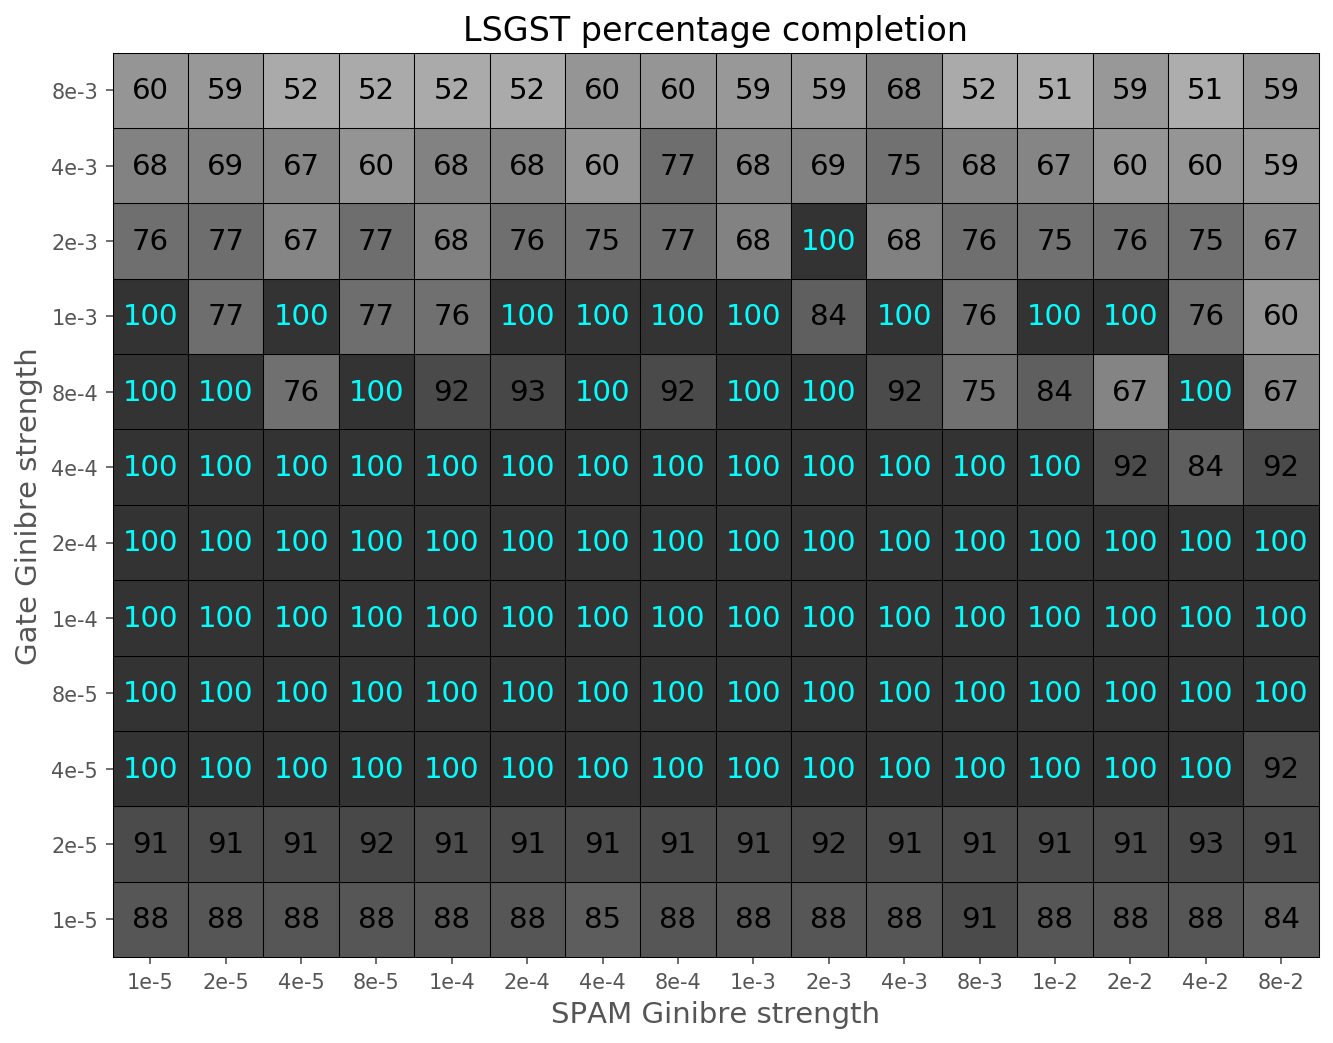

<Figure size 648x648 with 0 Axes>

In [16]:
# Read file and create new column to indicate completion
df = pd.read_csv(f"{output_prefix}/gate-newspam-fullsweep.csv")

df = df.sort_values(by=['GATE', 'STATE'])

results_matrix = np.zeros((len(gate_ginib_eps), len(state_ginib_eps)))

for gate in range(len(gate_ginib_eps)):
    for state in range(len(state_ginib_eps)):
        results_matrix[gate, state] = df.loc[(df['GATE'] == gate_ginib_eps[gate]) & (df['STATE'] == state_ginib_eps[state])]['COMPLETION']


plt.rcParams["figure.figsize"] = (9, 9)

fig, ax = plt.subplots()

ax.pcolor(results_matrix, edgecolors='k', linewidths=0.5, cmap="Greys", snap=True, vmin=0, vmax=120)
plt.xlabel("SPAM Ginibre strength", fontsize=14)
plt.xticks([x + 0.5 for x in range(len(state_ginib_eps))])
plt.ylabel("Gate Ginibre strength", fontsize=14)
plt.yticks([x + 0.5 for x in range(len(gate_ginib_eps))])
plt.title(f"LSGST percentage completion", fontsize=16)

[ax.spines[x].set_color('k') for x in ax.spines.keys()]
[ax.spines[x].set_linewidth(0.5) for x in ax.spines.keys()]

ax.set_aspect('equal')
# Use the code from the example to get the text on the grid
# https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
for i in range(results_matrix.shape[0]):
    for j in range(results_matrix.shape[1]):
        if np.isclose(results_matrix[i, j], 100):
            text = ax.text(j + 0.5, i + 0.5, int(results_matrix[i, j]), 
                           ha="center", va="center", color="cyan", fontsize=14)
        else:
            text = ax.text(j + 0.5, i + 0.5, int(results_matrix[i, j]), 
                           ha="center", va="center", color="black", fontsize=14)

ax.set_yticklabels([np.format_float_scientific(x, trim='-', exp_digits=1) for x in gate_ginib_eps])
ax.set_xticklabels([np.format_float_scientific(x, trim='-', exp_digits=1) for x in state_ginib_eps])

fig.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=10)

plt.show()
        
        
plt.savefig(f"grid-search-completion-percent.pdf")

In [18]:
data_file_list = os.listdir(output_prefix)

tvds = []

for gate_eps in gate_ginib_eps:
    for state_eps in state_ginib_eps:
        if f"-gate{gate_eps}-state{state_eps}-locs.npy" in data_file_list:
        # Plot all data
            particle_locations = np.load(f"{output_prefix}-gate{gate_eps}-state{state_eps}-locs.npy")
            particle_weights = np.load(f"{output_prefix}-gate{gate_eps}-state{state_eps}-wgts.npy").reshape((particle_locations.shape[0], 1))

            gate_data_map = {'Gx' : Gx_experimental_likelihood, 
                             'Gy' : Gy_experimental_likelihood, 
                             'Gi' : Gi_experimental_likelihood}

            total_tvd = 0
            
            for gate_idx, (gate, data) in enumerate(gate_data_map.items()):
                oqt_l, true_l, pyg_l = compute_likelihood_comparison(gate, data, particle_locations, particle_weights)
                oqt_tvd = tvd(gate_data_map[gate], oqt_l)                
                total_tvd += np.sum(oqt_tvd)

            tvds.append([gate_eps, state_eps, total_tvd])
        else:
            tvds.append([gate_eps, state_eps, 0])

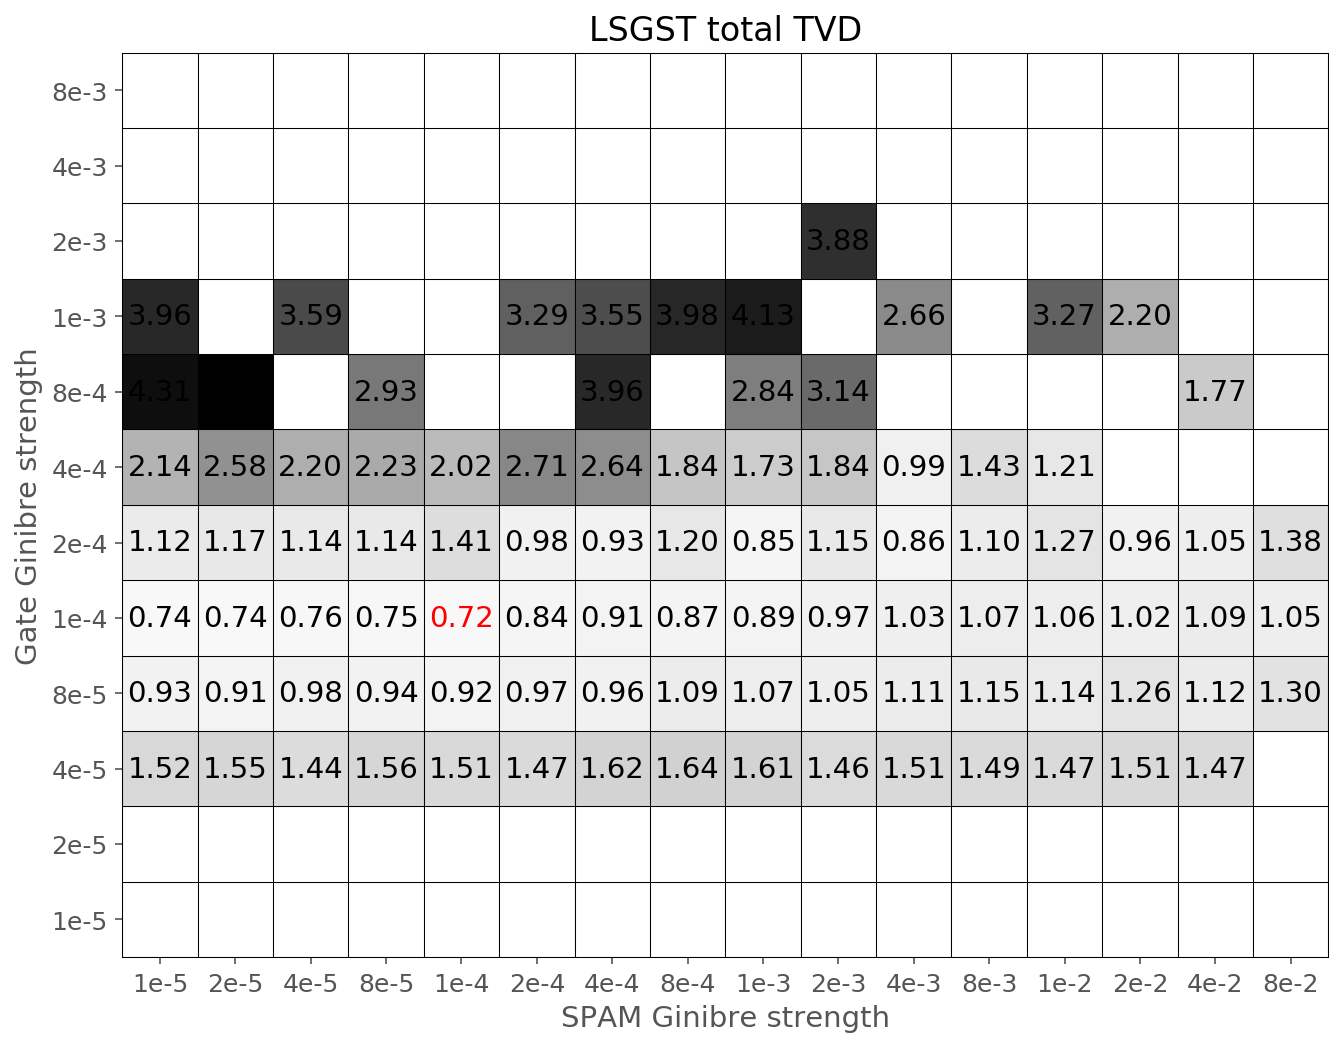

In [19]:
df['TVD'] = np.array(tvds)[:, 2]

tvd_matrix = np.zeros((len(gate_ginib_eps), len(state_ginib_eps)))

for gate in range(len(gate_ginib_eps)):
    for state in range(len(state_ginib_eps)):
        tvd_matrix[gate, state] = df.loc[(df['GATE'] == gate_ginib_eps[gate]) & (df['STATE'] == state_ginib_eps[state])]['TVD']

plt.rcParams["figure.figsize"] = (9, 9)

fig, ax = plt.subplots()

ax.pcolor(tvd_matrix, edgecolors='k', linewidths=0.5, cmap="Greys", snap=True, vmin=0.5, vmax=4.5)
plt.xlabel("SPAM Ginibre strength", fontsize=14)
plt.xticks([x + 0.5 for x in range(len(state_ginib_eps))])
plt.ylabel("Gate Ginibre strength", fontsize=14)
plt.yticks([x + 0.5 for x in range(len(gate_ginib_eps))])
plt.title(f"LSGST total TVD", fontsize=16)

[ax.spines[x].set_color('k') for x in ax.spines.keys()]
[ax.spines[x].set_linewidth(0.5) for x in ax.spines.keys()]

ax.set_aspect('equal')
# Use the code from the example to get the text on the grid
# https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
for i in range(tvd_matrix.shape[0]):
    for j in range(tvd_matrix.shape[1]):
        if tvd_matrix[i, j] > 0:
            if tvd_matrix[i, j] == np.min(tvd_matrix[np.nonzero(tvd_matrix)]):
                text = ax.text(j + 0.5, i + 0.5, f"{tvd_matrix[i, j]:.2f}", 
                               ha="center", va="center", color="red", fontsize=14)
            else:
                text = ax.text(j + 0.5, i + 0.5, f"{tvd_matrix[i, j]:.2f}", 
                               ha="center", va="center", color="black", fontsize=14)

                
ax.set_yticklabels([np.format_float_scientific(x, trim='-', exp_digits=1) for x in gate_ginib_eps])
ax.set_xticklabels([np.format_float_scientific(x, trim='-', exp_digits=1) for x in state_ginib_eps])

fig.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

#plt.savefig()

In [21]:
# Get the data from the best choice
particle_locations = np.load("../data/lsgst/grid-search/-gate0.0001-state0.0001-locs.npy")
particle_weights = np.load("../data/lsgst/grid-search/-gate0.0001-state0.0001-wgts.npy").reshape((particle_locations.shape[0], 1))

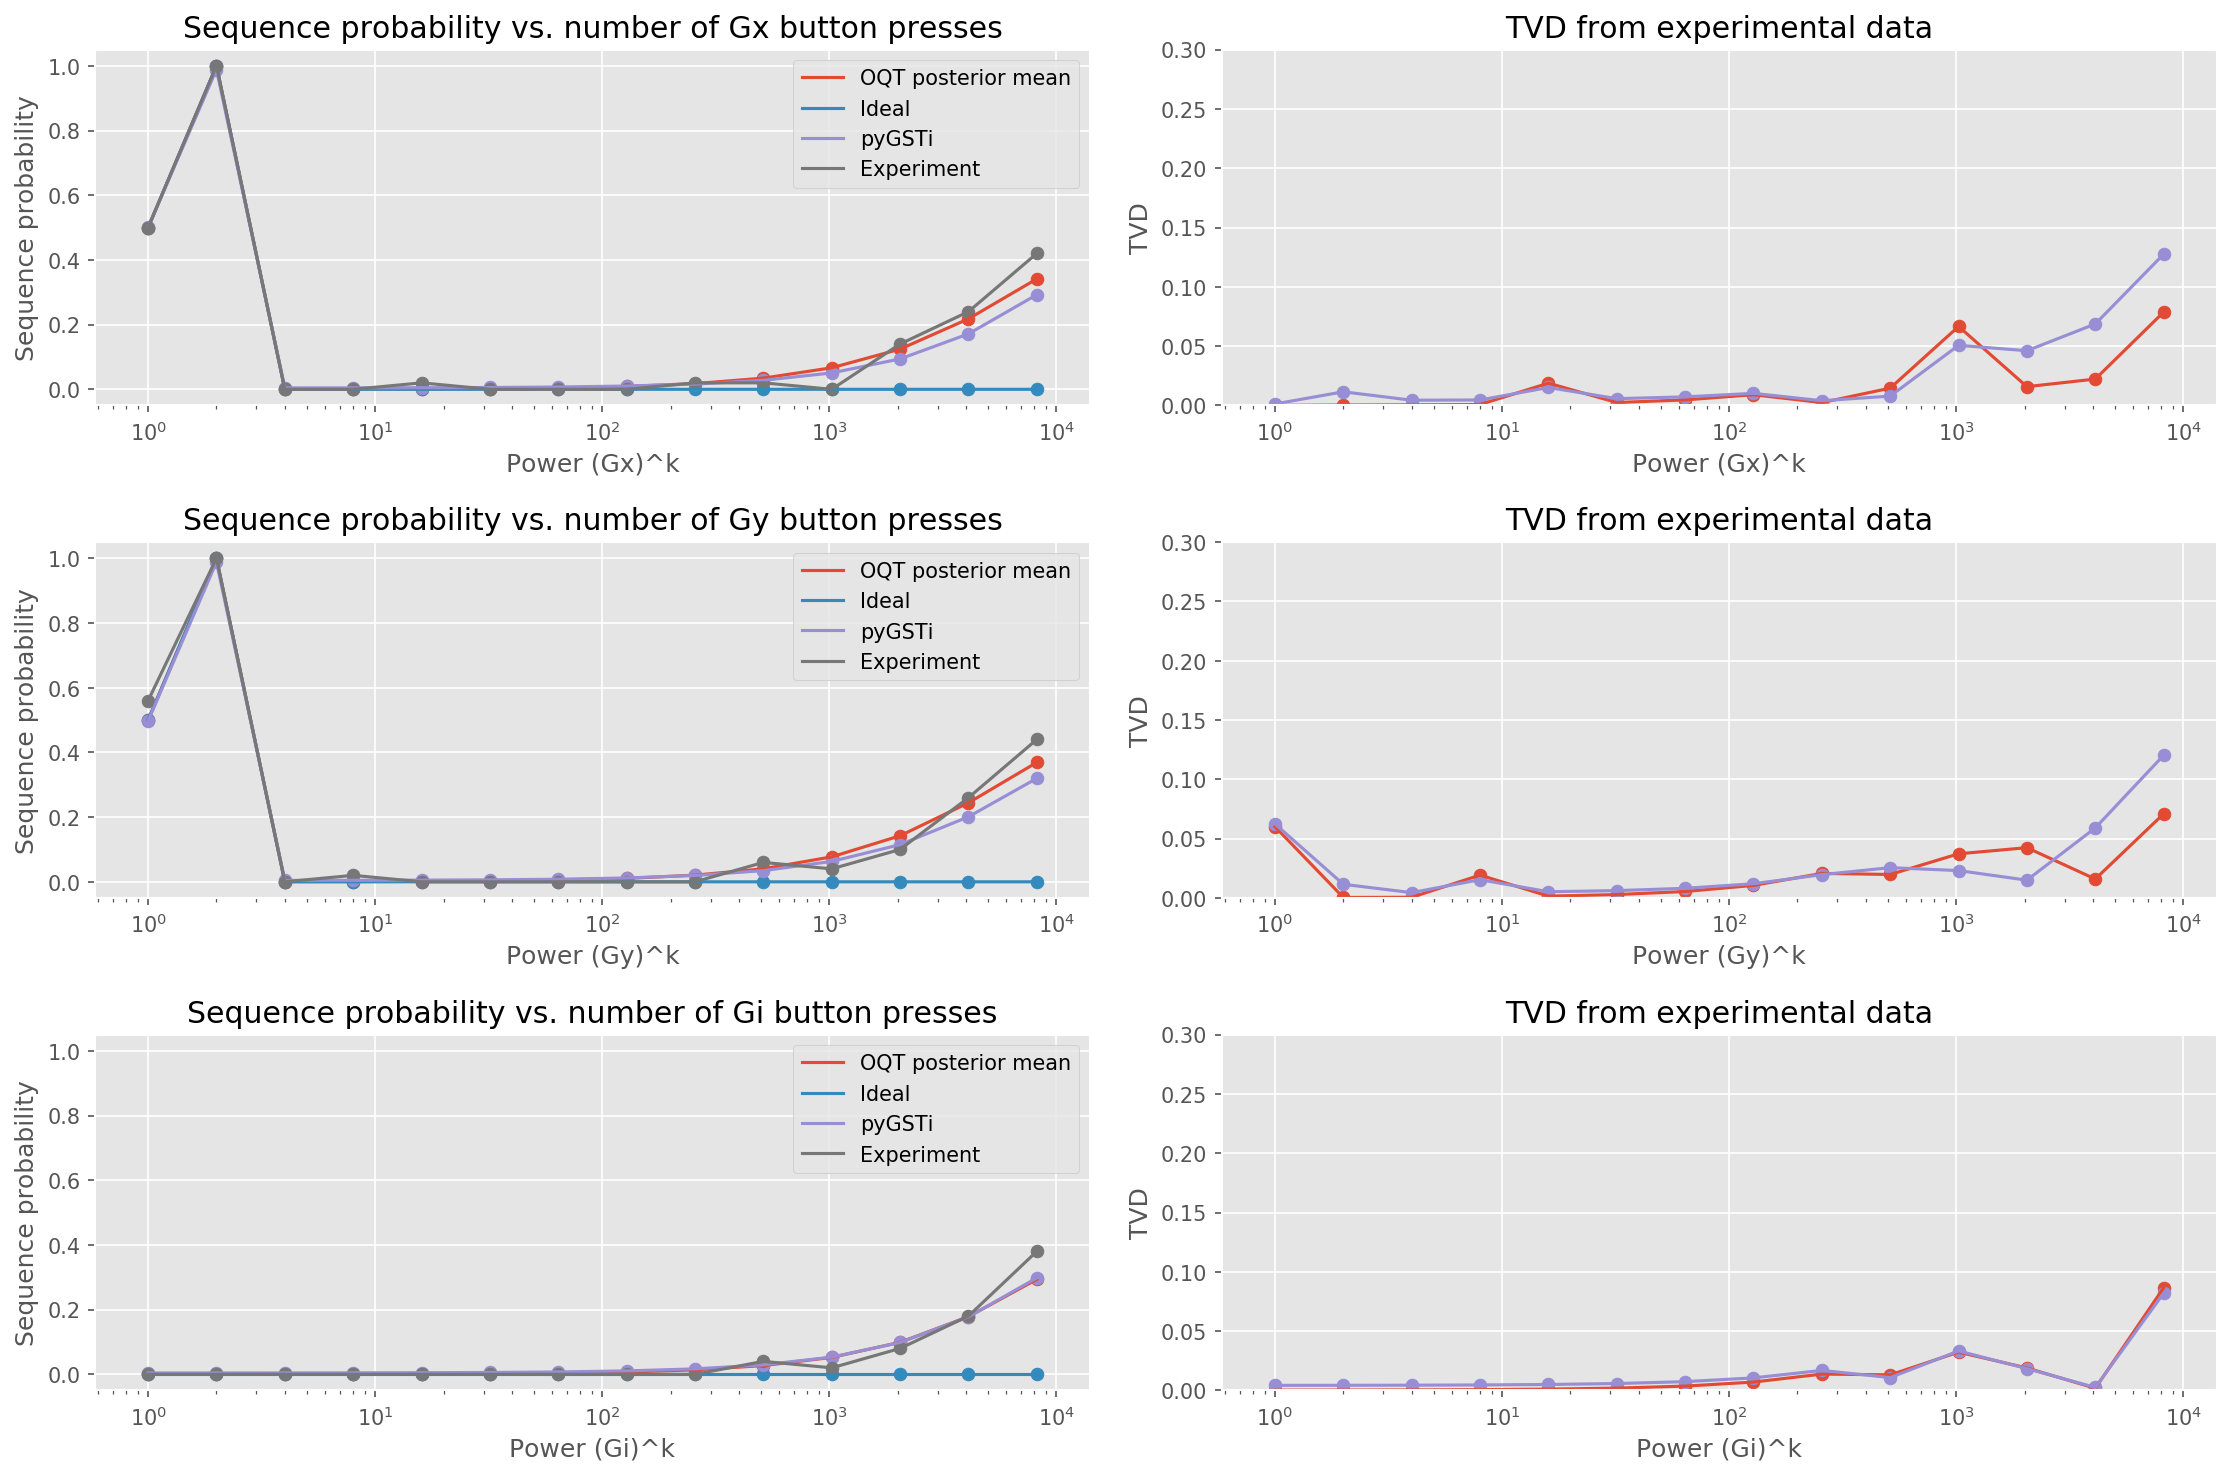

In [31]:
# Plot all data
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

total_oqt_tvd = 0
total_pyg_tvd = 0

gate_data_map = {'Gx' : Gx_experimental_likelihood, 
                 'Gy' : Gy_experimental_likelihood, 
                 'Gi' : Gi_experimental_likelihood}

for gate_idx, (gate, data) in enumerate(gate_data_map.items()):
    oqt_l, true_l, pyg_l = compute_likelihood_comparison(gate, data, particle_locations, particle_weights)
    plot_1c(gate, oqt_l, true_l, 1 - pyg_l, data, ax[gate_idx, 0])
    
    oqt_tvd = tvd(gate_data_map[gate], oqt_l)
    pyg_tvd = tvd(gate_data_map[gate], pyg_l)
    
    total_oqt_tvd += np.sum(oqt_tvd)
    total_pyg_tvd += np.sum(pyg_tvd)
    
    plot_tvd(gate, oqt_tvd, pyg_tvd, ax[gate_idx, 1])
    
plt.tight_layout()
plt.savefig(f"gridsearch_sample_1c_combined.pdf")

In [32]:
total_oqt_tvd

0.72431880783881

In [33]:
total_pyg_tvd

0.9609660572145853

In [ ]:
# Same plots, but do them separately so we can save them individually
for gate_idx, (gate, data) in enumerate(gate_data_map.items()):
    oqt_l, true_l, pyg_l = compute_likelihood_comparison(gate, data)
    
    plot_1c(gate, oqt_l, true_l, 1 - pyg_l, data)
    plt.savefig(f"{output_prefix}-{gate}-1c.pdf")
    plt.show()
    
    oqt_tvd = tvd(gate_data_map[gate], oqt_l)
    pyg_tvd = tvd(gate_data_map[gate], pyg_l)
    
    plot_tvd(gate, oqt_tvd, pyg_tvd)
    plt.savefig(f"{output_prefix}-{gate}-tvd.pdf")
    plt.show()

## Figure 4 copy

Generate a copy-cat of figure 4 where we compute difference between log-likelihoods.

In [23]:
# First, generate all the experiments that are used. Sandia's figure uses their 6 fiducials 
# with a germ power sandwiched in between.
from itertools import product
from scipy.stats import entropy

all_sequences = [exp['sequence'][0].flatten() for exp in full_experiments]

n_shots = 50
fiducials = [[], ['Gx'], ['Gy'], ['Gx', 'Gx'], ['Gx', 'Gx', 'Gx'], ['Gy', 'Gy', 'Gy']]

# The set of germs and powers used fo
germs = [['Gx', 'Gx', 'Gy', 'Gx', 'Gy', 'Gy'],
         ['Gx', 'Gy', 'Gy', 'Gi'],
         ['Gx', 'Gx', 'Gi', 'Gy'],
         ['Gy', 'Gi', 'Gi'],
         ['Gx', 'Gi', 'Gi'],
         ['Gx', 'Gi', 'Gy'],
         ['Gx', 'Gy', 'Gi'],
         ['Gx', 'Gy'],
         ['Gi'], 
         ['Gy'],
         ['Gx']]

# For each germ, generate the set of powers to be used
germ_powers = []
for germ in germs:    
    germ_powers.append([int(np.floor(2**m / len(germ))) for m in range(11)])

def markovianity_experiments(fiducials, germ, power, n_shots):
    exps = []
    
    for right_fid, left_fid in product(fiducials, repeat=2):
        new_experiment = np.empty((1,), dtype=model.expparams_dtype)
        new_experiment[0]['sequence'] = GSeq(left_fid + germ * power + right_fid)
        new_experiment[0]['n_meas'] = n_shots
        exps.append(new_experiment)

    return exps

In [24]:
# Now, a function to run an experiment to produce an estimate of the frequencies and take the difference with entropy
def delta_log_l(model, reconstructed_params, experiments):
    outcomes = np.array([0], dtype='uint')
    
    n_shots = experiments[0]['n_meas']
    
    # Get probabilites for each experiment
    p_s = np.array([model._underlying_model.likelihood(outcomes, reconstructed_params, experiment)[0, :, 0] for experiment in experiments]).reshape(len(experiments))

    # Now get experimental frequencies
    f_s = np.zeros(len(experiments))
    for idx_experiment, experiment in enumerate(experiments):
        f_s[idx_experiment] = full_outcomes[all_sequences.index(experiment['sequence'][0].flatten())] / n_shots


    comp_entropy = n_shots * np.sum(np.log(pow(f_s, f_s) * pow(1 - f_s, 1 - f_s)))
    l_max = n_shots * np.sum(np.log(pow(p_s, f_s) * pow(1 - p_s, 1 - f_s)))
    return 2 * (comp_entropy - l_max)[0]

In [25]:
reconstructed_params = np.array([np.sum(particle_weights * particle_locations, axis = 0)])

# An array to populate the table
log_likelihood_array = np.zeros((len(germs), 11))

for idx_germ, germ in enumerate(germs): # for each germ
    # These are the powers we will look at for this particular germ.
    # If the list is shorter than max_power, we will pad it with 0s after
    # the fact
    power_list = germ_powers[idx_germ]
    fill_offset = power_list.count(0)
    
    germ_likelihoods = np.zeros(len(germ_powers[idx_germ]))

    for idx_power, power in enumerate(power_list): # look at each non-zero power individually
        # Construct the experiments
        if power == 0:
            continue
        
        experiments = markovianity_experiments(fiducials, germ, power, n_shots)
 
        germ_likelihoods[idx_power] = delta_log_l(model, pygsti_params, experiments) 
      
    log_likelihood_array[idx_germ,:] = germ_likelihoods

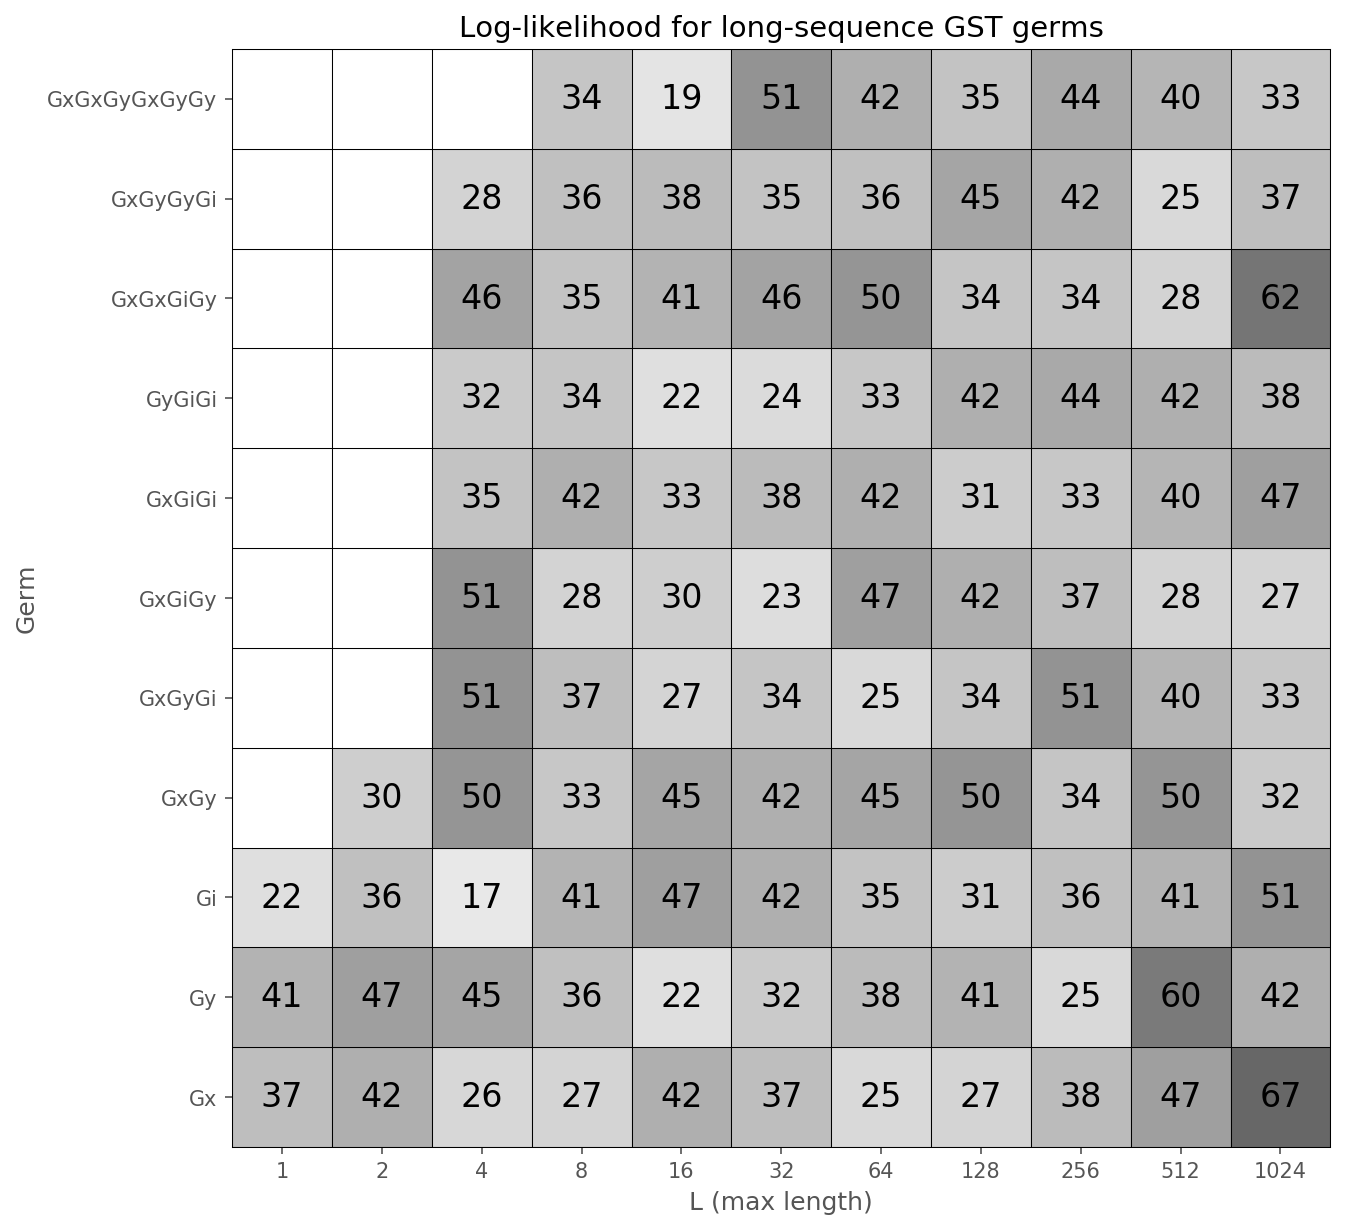

In [27]:
data = np.flipud(np.round(log_likelihood_array))
fig, ax = plt.subplots()

ax.pcolor(data, edgecolors='k', linewidths=0.5, cmap="Greys", snap=True, vmin=0, vmax=100)
plt.xlabel("L (max length)")
plt.xticks([x + 0.5 for x in range(11)])
plt.ylabel("Germ")
plt.yticks([x + 0.5 for x in range(11)])
plt.title("Log-likelihood for long-sequence GST germs", fontsize=14)

[ax.spines[x].set_color('k') for x in ax.spines.keys()]
[ax.spines[x].set_linewidth(0.5) for x in ax.spines.keys()]

ax.set_aspect('equal')
# Use the code from the example to get the text on the grid
# https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if int(data[i, j]) is not 0:
            text = ax.text(j + 0.5, i + 0.5, int(data[i, j]), 
                           ha="center", va="center", color="black", fontsize=16)

ax.set_yticklabels(["".join(germ) for germ in germs[::-1]])
ax.set_xticklabels([int(2**(x)) for x in range(11)], ha="center")
fig.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=10)
#plt.savefig(f'{output_prefix}-delta_log_likelihood.pdf')